## Exploring CVEfixes:
- Computing some statistics on the data, and generating some diagrams and tables from CVEfixes dataset 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as lite
from sqlite3 import Error
from pathlib import Path
from datetime import date
import numpy as np
import seaborn as sns
import matplotlib.ticker as tick
import requests
import difflib as diff
import re 
import csv
import ast
%matplotlib inline

# pd.set_option('mode.chained_assignment', None)

def create_connection(db_file):
    """
    create a connection to sqlite3 database
    """
    conn = None
    try:
        conn = lite.connect(db_file, timeout=10)  # connection via sqlite3
        # engine = sa.create_engine('sqlite:///' + db_file)  # connection via sqlalchemy
        # conn = engine.connect()
    except Error as e:
        print(e)
    return conn


DATA_PATH = Path.cwd().parents[0] / 'Data'
FIGURE_PATH = Path.cwd() / 'figures'
RESULT_PATH = Path.cwd() / 'results'

Path(DATA_PATH).mkdir(parents=True, exist_ok=True)
Path(FIGURE_PATH).mkdir(parents=True, exist_ok=True)
Path(RESULT_PATH).mkdir(parents=True, exist_ok=True)

conn = create_connection(DATA_PATH / "CVEfixes.db")

### Quering to CVEfixes database to get the parts as the separate datasets

- An example query to retrieve all the methods of C programming language. 

In [2]:
df_c_methods = pd.read_sql_query("SELECT m.name, m.signature, m.nloc, \
m.parameters, m.token_count, m.code, m.before_change, f.programming_language FROM method_change m, file_change f \
WHERE f.file_change_id=m.file_change_id AND f.programming_language='C'", conn)
df_c_methods.head(5)

,name,signature,nloc,parameters,token_count,code,before_change,programming_language
0,check_1_6_dummy,"check_1_6_dummy( kadm5_principal_ent_t entry ,...",13,"['entry', 'mask', 'n_ks_tuple', 'ks_tuple', 'p...",94,"check_1_6_dummy(kadm5_principal_ent_t entry, l...",True,C
1,check_1_6_dummy,"check_1_6_dummy( kadm5_principal_ent_t entry ,...",13,"['entry', 'mask', 'n_ks_tuple', 'ks_tuple', 'p...",98,"check_1_6_dummy(kadm5_principal_ent_t entry, l...",False,C
2,process_chpw_request,"process_chpw_request( krb5_context context , v...",309,"['context', 'server_handle', 'realm', 'keytab'...",1935,"process_chpw_request(krb5_context context, voi...",False,C
3,process_chpw_request,"process_chpw_request( krb5_context context , v...",309,"['context', 'server_handle', 'realm', 'keytab'...",1935,"process_chpw_request(krb5_context context, voi...",True,C
4,init_ctx_reselect,"init_ctx_reselect( OM_uint32 * minor_status , ...",25,"['minor_status', 'sc', 'acc_negState', 'suppor...",162,"init_ctx_reselect(OM_uint32 *minor_status, spn...",True,C


- Another example of query to extract all the files that have added/removed only a single statement to fix the vulnerabilities.

In [3]:
query = """
SELECT cv.cve_id, f.filename, f.num_lines_added, f.num_lines_deleted, f.code_before, f.code_after, cc.cwe_id 
FROM file_change f, commits c, fixes fx, cve cv, cwe_classification cc
WHERE f.hash = c.hash 
AND c.hash = fx.hash 
AND fx.cve_id = cv.cve_id 
AND cv.cve_id = cc.cve_id 
AND f.num_lines_added<=1 
AND f.num_lines_deleted<=1;
"""
java_single_line_fixes = pd.read_sql_query(query, conn)
java_single_line_fixes.head(5)

,cve_id,filename,num_lines_added,num_lines_deleted,code_before,code_after,cwe_id
0,CVE-1999-0731,saver.cpp,1,0,#include <pwd.h>\n#include <unistd.h>\n#includ...,#include <pwd.h>\n#include <unistd.h>\n#includ...,NVD-CWE-Other
1,CVE-2012-1013,svr_principal.c,1,1,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,NVD-CWE-Other
2,CVE-2014-4343,spnego_mech.c,0,1,"/*\n * Copyright (C) 2006,2008 by the Massachu...","/*\n * Copyright (C) 2006,2008 by the Massachu...",CWE-415
3,CVE-2014-4344,spnego_mech.c,1,1,"/*\n * Copyright (C) 2006,2008 by the Massachu...","/*\n * Copyright (C) 2006,2008 by the Massachu...",CWE-476
4,CVE-2014-5352,context_time.c,1,1,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,NVD-CWE-Other


# Statistics on _CVEfixes_ data

- Loading tables into dataframes for further processing

In [4]:
df_commit = pd.read_sql('SELECT * FROM commits', con=conn)
df_file = pd.read_sql('SELECT * FROM file_change', con=conn)
df_method = pd.read_sql('SELECT * FROM method_change', con=conn)
df_cve = pd.read_sql('SELECT * FROM cve', con=conn)
df_fixes = pd.read_sql('SELECT * FROM fixes', con=conn)
df_cwe_class = pd.read_sql('SELECT * FROM cwe_classification', con=conn)
df_cwe = pd.read_sql('SELECT * FROM cwe', con=conn)
df_repo = pd.read_sql('SELECT * FROM repository', con = conn)

## Top 10 major projects that have contributed most of the vulnerability data

In [5]:
commit_freq_query = """
SELECT fx.repo_url as commit_project, count(fx.hash) as commit_count
FROM commits c, fixes fx
WHERE fx.hash=c.hash
GROUP BY fx.repo_url
ORDER BY commit_count DESC;
"""

file_freq_query = """
SELECT fx.repo_url as file_project, count(f.file_change_id) as file_count 
FROM commits c, fixes fx, file_change f
WHERE fx.hash=c.hash
AND c.hash = f.hash
GROUP BY fx.repo_url
ORDER BY file_count DESC;
"""
method_freq_query = """
SELECT fx.repo_url as method_project, count(m.method_change_id) as method_count 
FROM commits c, fixes fx, file_change f, method_change m
WHERE fx.hash=c.hash
AND c.hash = f.hash
AND f.file_change_id = m.file_change_id
GROUP BY fx.repo_url
ORDER BY method_count DESC;
"""

df_commit_freq = pd.read_sql_query(commit_freq_query, con=conn)
df_file_freq = pd.read_sql_query(file_freq_query, con=conn)
df_method_freq = pd.read_sql_query(method_freq_query, con=conn)

- Ordering the projects on the basis of number of commits:

In [6]:
df_meta = df_commit_freq.merge(df_file_freq, 
                               left_on='commit_project', 
                               right_on='file_project').merge(df_method_freq, 
                                                             left_on='commit_project', 
                                                             right_on='method_project')
df_meta = df_meta.replace(np.nan,0)
df_meta['commit_project'] = df_meta['commit_project'].str.split('/').str[-1]
df_meta = df_meta.drop(['file_project','method_project'], axis=1)
df_meta[['commit_count','file_count', 'method_count']] = df_meta[['commit_count','file_count', 'method_count']].astype(int)
df_meta=df_meta.sort_values(by=['commit_count','file_count','method_count'], ascending=False)
df_meta.head(10)

,commit_project,commit_count,file_count,method_count
0,linux,1029,2007,4303
1,ImageMagick,171,256,512
2,tensorflow,156,340,1045
3,phpmyadmin,126,242,222
4,tcpdump,101,344,299
5,FFmpeg,88,104,213
6,php-src,61,129,454
7,MISP,54,87,98
8,WordPress,47,190,915
9,radare2,43,60,141


### Ordering the projects on the basis of #commits, #files and #methods separately in a table. 

In [7]:
df_merged = pd.concat([df_commit_freq, df_file_freq], axis=1)
df_merged = pd.concat([df_merged, df_method_freq], axis=1)
df_merged = df_merged.replace(np.nan, 0)
df_merged['commit_project'] = df_merged['commit_project'].str.split('/').str[-1]
df_merged['file_project'] = df_merged['file_project'].str.split('/').str[-1]
df_merged['method_project'] = df_merged['method_project'].str.split('/').str[-1]

df_merged[['commit_count','file_count', 'method_count']] = df_merged[['commit_count','file_count', 'method_count']].astype(int)
df_merged = df_merged.replace('_','-', regex=True)

df_merged.head(10).to_csv(RESULT_PATH / 'vul_projects_10.csv', index=False)
df_merged.head(10)

,commit_project,commit_count,file_project,file_count,method_project,method_count
0,linux,1029,linux,2007,GeniXCMS,14235
1,ImageMagick,171,GeniXCMS,1930,linux,4303
2,tensorflow,156,kanboard,698,exponent-cms,3048
3,phpmyadmin,126,CycloneTCP,611,Ilch-2.0,1427
4,tcpdump,101,X2CRM,594,arangodb,1224
5,FFmpeg,88,exponent-cms,445,kanboard,1169
6,php-src,61,Ushahidi-Web,402,tensorflow,1045
7,MISP,54,wityCMS,372,moped,950
8,WordPress,47,tcpdump,344,WordPress,915
9,radare2,43,tensorflow,340,X2CRM,790


## Count of CVEs and CWEs on top 10 major projects

In [8]:
cve_freq_query = """
SELECT fx.repo_url AS projects, count(DISTINCT fx.cve_id) AS cve_count, count(DISTINCT cc.cwe_id) as cwe_count
FROM fixes fx, cve cv, cwe_classification cc
WHERE fx.cve_id=cv.cve_id
AND cv.cve_id=cc.cve_id
GROUP by projects 
ORDER BY cve_count DESC;
"""
df_cve_cwe = pd.read_sql(cve_freq_query, con=conn)
df_cve_cwe_urls = df_cve_cwe.copy()
df_cve_cwe['projects']= df_cve_cwe['projects'].str.split('/').str[-1]
df_cve_cwe = df_cve_cwe.replace('_','-', regex=True)
df_cve_cwe.head(10).to_csv(RESULT_PATH / 'dataset_summary_cve_cwe.csv', index=False)
df_cve_cwe.head(10)

,projects,cve_count,cwe_count
0,linux,973,53
1,ImageMagick,157,27
2,tensorflow,143,24
3,tcpdump,89,4
4,FFmpeg,83,17
5,phpmyadmin,67,13
6,php-src,60,17
7,MISP,50,17
8,WordPress,46,14
9,radare2,40,6


## Count of CWEs present at file- and method level data:

In [9]:
cwe_count_query = """
SELECT cc.cwe_id as CWE, cw.cwe_name as description, count(DISTINCT cc.cve_id) cve_count,  count(DISTINCT c.hash) as commit_count, count(DISTINCT f.file_change_id) file_count, count(DISTINCT m.method_change_id) method_count
FROM cve cv
JOIN cwe_classification cc ON cv.cve_id=cc.cve_id
JOIN cwe cw ON cc.cwe_id=cw.cwe_id
JOIN fixes fx ON cv.cve_id=fx.cve_id
JOIN commits c ON fx.hash=c.hash
LEFT JOIN file_change f ON c.hash= f.hash
LEFT JOIN method_change m ON f.file_change_id=m.file_change_id
GROUP BY cc.cwe_id
ORDER BY cve_count DESC;
"""
df_cwe_result = pd.read_sql(cwe_count_query, con=conn)
df_cwe_result = df_cwe_result.sort_values(by=['cve_count'], ascending=False)
df_cwe_result = df_cwe_result.replace('"','', regex=True).replace("'",'', regex=True).replace(',','', regex=True)
df_cwe_result[['CWE','description','cve_count','commit_count','file_count']].head(10).to_csv(RESULT_PATH / 'cwe_summary.csv', index=False)
print('# CWEs: ' + str(df_cwe_result.CWE.nunique()))
df_cwe_result.head(10)

# CWEs: 180


,CWE,description,cve_count,commit_count,file_count,method_count
0,CWE-79,Improper Neutralization of Input During Web Pa...,635,670,3226,7626
1,CWE-119,Improper Restriction of Operations within the ...,408,403,716,1651
2,CWE-20,Improper Input Validation,382,397,1965,3140
3,CWE-125,Out-of-bounds Read,380,404,1061,2373
4,CWE-200,Exposure of Sensitive Information to an Unauth...,276,314,818,1033
5,CWE-787,Out-of-bounds Write,205,211,537,1486
6,CWE-476,NULL Pointer Dereference,195,198,334,678
7,NVD-CWE-noinfo,Insufficient Information,193,219,664,1134
8,NVD-CWE-Other,Other,165,170,395,768
9,CWE-264,Permissions Privileges and Access Controls,143,148,457,924


## The proportion of the top 10 major projects at different granular levels:

In [10]:
percent_10_cve = (df_cve_cwe.cve_count.head(10).sum()/df_cve.cve_id.nunique())*100
percent_10_commit = (df_merged.commit_count.head(10).sum()/df_merged.commit_count.sum())*100
percent_10_file = df_merged.file_count.head(10).sum()/df_file.file_change_id.nunique()*100
percent_10_method = df_merged.method_count.head(10).sum()/df_method.method_change_id.nunique()*100

# CWEs proportion 10 major projects out of the total CWEs based in file data:
# percent_10_cwe_cve = (df_cwe_result['cve_count'].head(10).sum()/df_cve.cve_id.nunique())*100
percent_10_cwe_cve = (df_cwe_result['cve_count'].head(10).sum()/df_cve.cve_id.count())*100

percent_10_cwe_commit = (df_cwe_result['commit_count'].head(10).sum()/len(df_commit))*100

#percent_10_cwe_file = (df_cwe_result['file_count'].head(10).sum()/df_file.file_change_id.nunique())*100
percent_10_cwe_file = (df_cwe_result['file_count'].head(10).sum()/df_file.file_change_id.count())*100
percent_10_cwe_method = (df_cwe_result['method_count'].head(10).sum()/df_method.method_change_id.count())*100

print('Proportion of 10 major projects out of the total projects at different granular levels:')
print('% CVEs: ', percent_10_cve.round(2))
print('% commits: ', percent_10_commit.round(2))
print('% files: ', percent_10_file.round(2))
print('% method: ',percent_10_method.round(2))

print('\n% CWEs at CVEs: ',percent_10_cwe_cve.round(2))
print('% CWEs at Commits: ',percent_10_cwe_commit.round(2))
print('% CWEs at files: ',percent_10_cwe_file.round(2))
print('% CWEs at methods ',percent_10_cwe_method.round(2))

Proportion of 10 major projects out of the total projects at different granular levels:
% CVEs:  31.84
% commits:  31.61
% files:  42.43
% method:  57.84

% CWEs at CVEs:  55.58
% CWEs at Commits:  57.02
% CWEs at files:  55.75
% CWEs at methods  41.36


## The summary of _CVEfixes_ database

In [11]:
data_summary = {
'CVEs': df_fixes.cve_id.nunique(),
'CWEs': df_cwe_result.CWE.nunique(),
'projects':df_merged.commit_project.count(),
'commits': df_commit.hash.nunique(),           
'files': df_file.file_change_id.nunique(),
'methods': df_method.method_change_id.count()
}
print('#CVEs registered in CVE database : ' + str(df_cve.cve_id.nunique()))
print('#commits registered in CVE database : ' + str(df_fixes.hash.nunique()))
print('#projects registered in CVE database : ' + str(df_fixes.repo_url.nunique()))
print("#programming languages/file formats: " + str(df_file.programming_language.value_counts().count()-1))

pd.DataFrame([data_summary]).to_csv(RESULT_PATH / 'dataset_summary.csv', index=False)
pd.DataFrame([data_summary])

#CVEs registered in CVE database : 5365
#commits registered in CVE database : 5495
#projects registered in CVE database : 1754
#programming languages/file formats: 31


,CVEs,CWEs,projects,commits,files,methods
0,5365,180,1754,5495,18249,50322


# Plotting of the CVSS severity scores of all CVE records using different diagrams

In [12]:
def show_plot(plot_type, df_plot, x_label, y_label):
    df_plot = df_plot.astype(float)
    fig, axs = plt.subplots()
    if plot_type=='boxplot':
        ax = sns.boxplot(data=df_plot, ax=axs, orient='h')
    if plot_type=='violinplot':
        ax = sns.violinplot(data=df_plot, ax=axs, orient='h')
    axs.yaxis.grid(True)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.yticks(rotation=40)
    fig.tight_layout()
    return fig,axs

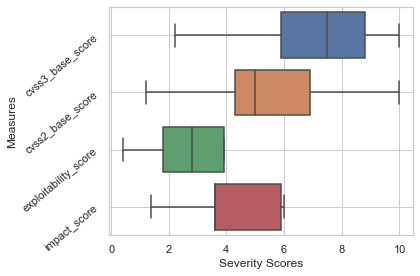

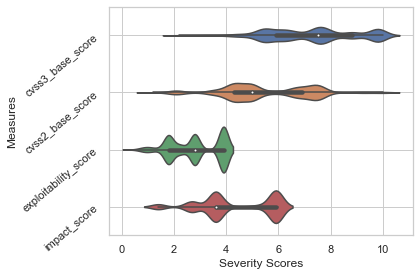

In [13]:
sns.set(style="whitegrid")

df_cvss = df_cve.dropna()
df_cvss = df_cvss[df_cvss.cvss3_base_score!='nan']
df_cvss=df_cvss[['cvss3_base_score','cvss2_base_score','exploitability_score','impact_score']].reset_index(drop=True)

fig,axs = show_plot('boxplot', df_cvss, 'Severity Scores', 'Measures')
fig,axs = show_plot('violinplot', df_cvss, 'Severity Scores', 'Measures')

## Plotting of the average CVSS severity scores of all the reported projects  in the database.

In [14]:
score_query = """
SELECT fx.repo_url AS projects,
    count(fx.cve_id) AS cve_count,
    AVG(NULLIF(v.cvss3_base_score,0)) AS avg_cvss_v3_score, 
    AVG(NULLIF(v.cvss2_base_score,0)) AS avg_cvss_v2_score, 
    AVG(NULLIF(v.exploitability_score,0)) AS avg_exploitability_score, 
    AVG(NULLIF(v.impact_score,0)) AS avg_impact_score
FROM fixes fx, cve v
WHERE fx.cve_id = v.cve_id
GROUP BY projects
ORDER BY cve_count DESC;
"""
df_score = pd.read_sql(score_query, conn)
df_score = df_score.round(2)
#df_score['projects'] = df_score.projects.str.split('/').str[-1]
df_score.head(10)

,projects,cve_count,avg_cvss_v3_score,avg_cvss_v2_score,avg_exploitability_score,avg_impact_score
0,https://github.com/torvalds/linux,1029,3.99,5.30,1.16,2.78
1,https://github.com/ImageMagick/ImageMagick,171,7.25,5.45,2.74,4.43
2,https://github.com/tensorflow/tensorflow,156,6.67,3.92,2.05,4.50
3,https://github.com/phpmyadmin/phpmyadmin,126,3.55,4.46,1.85,1.53
4,https://github.com/the-tcpdump-group/tcpdump,101,9.57,7.33,3.86,5.70
5,https://github.com/FFmpeg/FFmpeg,88,5.86,6.35,2.23,3.57
6,https://github.com/php/php-src,61,7.46,6.59,3.22,4.21
7,https://github.com/MISP/MISP,54,6.70,5.03,2.81,3.61
8,https://github.com/WordPress/WordPress,47,7.01,5.27,3.06,3.66
9,https://github.com/radare/radare2,43,6.30,5.13,1.85,4.35


## Computing the statistics on the days to fix vulnerabilities of each project. 

In [15]:
def dates_diff(commit_date, publish_date):
    pyear, pmonth, pday = publish_date.split('-')
    publish_date = date(int(pyear), int(pmonth), int(pday.split('T')[0]))
    
    cyear,cmonth,cday  = commit_date.split(' ')[0].split('-')
    commit_date = date(int(cyear), int(cmonth), int(cday))

    diff_days = abs(commit_date - publish_date).days
    return round(diff_days, 2)

In [16]:
# df_dif_days = pd.merge(df_project, df_cve, on='cve_id')
# df_dif_days = pd.merge(dfc, df_dif_days, on='hash')

fix_days_query = """
SELECT fx.repo_url as project, published_date, committer_date FROM cve cv, fixes fx, commits c
WHERE cv.cve_id=fx.cve_id
AND fx.hash=c.hash
"""
df_fix_days = pd.read_sql(fix_days_query, conn)
#df_fix_days['project'] = df_fix_days.project.str.split('/').str[-1]


df_date = df_fix_days[['project','published_date','committer_date']].copy()
df_date["mean_days_to_fix"] = df_date.apply(lambda x: dates_diff(x.committer_date, x.published_date), axis=1)
# df_date = df_date.groupby('project', as_index=False)['mean_days_to_fix'].mean().sort_values(by=['mean_days_to_fix'], ascending=False, na_position='first').reset_index(drop=True)
df_date = df_date.groupby('project', as_index=False).agg({'mean_days_to_fix': ['mean','median','max','min']})
df_date.reset_index(drop=True)
df_date = df_date.round(3)
df_date.columns = ['project','mean_days_to_fix','median_days_to_fix', 'max_days_to_fix','min_days_to_fix']
df_date.head(10)

,project,mean_days_to_fix,median_days_to_fix,max_days_to_fix,min_days_to_fix
0,https://bitbucket.org/butor-team/portal,89.000,89.0,89,89
1,https://bitbucket.org/connect2id/nimbus-jose-jwt,96.333,80.0,129,80
2,https://bitbucket.org/jeromerobert/k4dirstat,164.000,164.0,164,164
3,https://bitbucket.org/libgd/gd-libgd,107.000,107.0,107,107
4,https://bitbucket.org/naviserver/naviserver,0.000,0.0,0,0
5,https://bitbucket.org/ritt/elog,32.000,32.0,32,32
6,https://bitbucket.org/tildeslash/monit,210.750,49.0,696,49
7,https://github.com/01org/opa-ff,630.000,630.0,630,630
8,https://github.com/01org/opa-fm,626.500,626.5,628,625
9,https://github.com/01org/tpm2.0-tools,6.000,6.0,6,6


## Adding avg_days_to_fix and cwe_count to the severity_summary table

In [17]:
# adding cwe_count to the table
df_score1=df_score.drop('cve_count', axis=1)

df_score_all = pd.merge(df_score1, df_cve_cwe_urls, on="projects")
df_score_all.rename(columns={'cve_project':'projects'}, inplace=True)

# adding average days to fix vulnerability column - avg_days_to_fix
df_score_all = pd.merge(df_score_all, df_date, left_on='projects', right_on = 'project', how='left').drop(columns=['project'], axis=1)
df_score_all = np.round(df_score_all, decimals=3)
df_score_all['projects'] = df_score_all.projects.str.split('/').str[-1]

df_score_all = df_score_all.sort_values(by=['cve_count'], ascending=False)
df_score_all.to_csv(RESULT_PATH / 'severity_summary.csv', index=False)
df_score_all.head(10)

,projects,avg_cvss_v3_score,avg_cvss_v2_score,avg_exploitability_score,avg_impact_score,cve_count,cwe_count,mean_days_to_fix,median_days_to_fix,max_days_to_fix,min_days_to_fix
0,linux,3.99,5.30,1.16,2.78,973,53,213.643,49.0,4582,0
1,ImageMagick,7.25,5.45,2.74,4.43,157,27,190.140,75.0,1474,1
2,tensorflow,6.67,3.92,2.05,4.50,143,24,22.154,16.0,810,2
4,tcpdump,9.57,7.33,3.86,5.70,89,4,12.960,1.0,918,1
5,FFmpeg,5.86,6.35,2.23,3.57,83,17,63.216,44.0,1523,1
3,phpmyadmin,3.55,4.46,1.85,1.53,67,13,36.151,13.0,1211,1
6,php-src,7.46,6.59,3.22,4.21,60,17,50.262,27.0,855,3
7,MISP,6.70,5.03,2.81,3.61,50,17,29.333,1.0,430,0
8,WordPress,7.01,5.27,3.06,3.66,46,14,18.170,4.0,217,2
10,hhvm,7.54,6.48,3.22,4.31,40,18,182.175,37.0,1328,1


## Plotting overall severity scores of the database. 

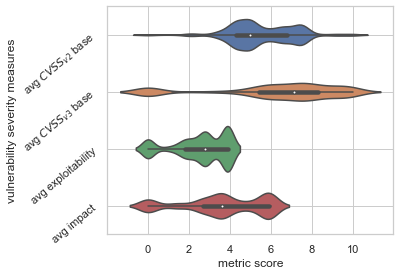

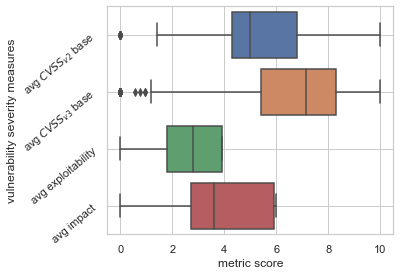

In [18]:
df_sev_plot = df_score[['avg_cvss_v2_score', 'avg_cvss_v3_score', 'avg_exploitability_score', 'avg_impact_score']]

fig, axs = show_plot('violinplot', df_sev_plot, 'metric score', 'vulnerability severity measures')
axs.set_yticklabels(('avg $CVSS_{v2}$ base','avg $CVSS_{v3}$ base','avg exploitability','avg impact'))
fig.savefig(FIGURE_PATH / 'severity_violin.pdf')

fig, axs = show_plot('boxplot', df_sev_plot, 'metric score', 'vulnerability severity measures')
axs.set_yticklabels(('avg $CVSS_{v2}$ base','avg $CVSS_{v3}$ base','avg exploitability','avg impact'))
fig.savefig(FIGURE_PATH / 'severity_boxplot.pdf')


## Plotting dmm_complexity of the commits

1) DMM scores grouped by projects:

,projects,avg_unit_size,avg_unit_complexity,avg_unit_interfacing,avg_unit_score
0,portal,0.00,0.00,1.00,0.333333
1,nimbus-jose-jwt,0.40,0.80,0.87,0.690000
2,k4dirstat,0.00,0.00,0.00,0.000000
3,gd-libgd,0.00,0.00,0.00,0.000000
4,naviserver,0.00,0.00,1.00,0.333333
5,elog,0.00,0.00,0.50,0.166667
6,monit,0.02,0.04,0.16,0.073333
7,opa-ff,0.00,0.00,0.00,0.000000
8,opa-fm,0.00,0.00,0.50,0.166667
9,tpm2.0-tools,0.33,0.33,0.33,0.330000


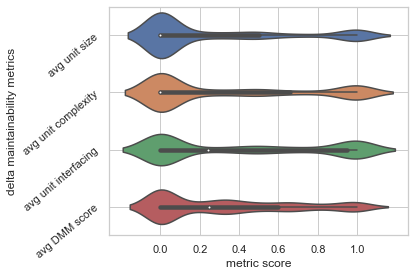

In [19]:
avg_dmm_query = """
SELECT repo_url AS projects,
    AVG(NULLIF(dmm_unit_size,0)) AS avg_unit_size,
    AVG(NULLIF(dmm_unit_complexity, 0)) AS avg_unit_complexity, 
    AVG(NULLIF(dmm_unit_interfacing, 0)) AS avg_unit_interfacing
FROM commits
GROUP BY projects;
"""
df_avg_dmm = pd.read_sql(avg_dmm_query, conn)
df_avg_dmm = df_avg_dmm.round(2)
df_avg_dmm['avg_unit_score'] = (df_avg_dmm.avg_unit_size + df_avg_dmm.avg_unit_complexity + df_avg_dmm.avg_unit_interfacing) / 3
df_avg_dmm['projects'] = df_avg_dmm.projects.str.split('/').str[-1]

plt.ion()
fig, axs = show_plot('violinplot', df_avg_dmm[['avg_unit_size', 'avg_unit_complexity',
       'avg_unit_interfacing', 'avg_unit_score']], 'metric score', 'delta maintainability metrics')
axs.set_xticks(np.arange(0.0, 1.2, 0.2))
axs.set_yticklabels(('avg unit size','avg unit complexity','avg unit interfacing','avg DMM score'))
fig.savefig(FIGURE_PATH / 'dmm_avg_complexity_plot.pdf')
df_avg_dmm.head(15)

In [37]:
print('Proportion of projects with above average risk code changes = ', 
      len(df_avg_dmm[df_avg_dmm.avg_unit_score<0.5])/len(df_avg_dmm)*100)

Proportion of projects with above average risk code changes =  69.72633979475485


2) DMM scores of all the commits: 

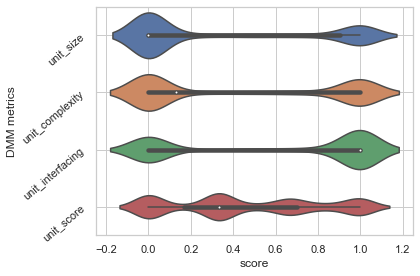

In [20]:
df_dmmcom = df_commit[['dmm_unit_size','dmm_unit_complexity','dmm_unit_interfacing']]
df_dmmcom = df_dmmcom.replace("None", value=np.nan).dropna().astype(float)
df_dmmcom.columns = df_dmmcom.columns.str.replace(r"dmm_", "")
df_dmmcom['unit_score'] = (df_dmmcom.unit_size + df_dmmcom.unit_complexity + df_dmmcom.unit_interfacing) / 3

fig,axs = show_plot('violinplot', df_dmmcom, 'score', 'DMM metrics')
fig.savefig(FIGURE_PATH / 'dmm_complexity_plot.pdf')

In [38]:
print('Proportion of individual above average risk code changes = ', 
      len(df_dmmcom[df_dmmcom.unit_score<0.5])/len(df_dmmcom)*100)

Proportion of individual above average risk code changes =  43.47086346235645


In [22]:
sns.set(font_scale=1.4)

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

In [49]:
print(df_file.programming_language.value_counts())

C                   4224
PHP                 3560
unknown             1479
C++                 1263
JavaScript          1215
Markdown             976
Python               718
Ruby                 705
Java                 640
HTML                 538
Shell                450
Go                   373
TypeScript           337
Objective-C          226
SQL                  212
C#                   202
CSS                  185
Perl                 181
Batchfile            170
CoffeeScript         148
Scala                103
PowerShell            70
Haskell               55
Lua                   45
TeX                   37
Jupyter Notebook      34
Rust                  33
Swift                 32
R                     14
Matlab                13
Erlang                 8
None                   3
Name: programming_language, dtype: int64


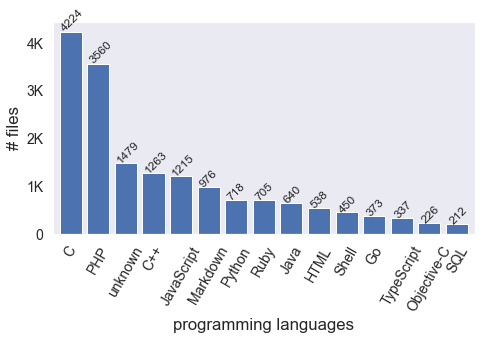

In [23]:
# at file level
ax = df_file.programming_language.value_counts().head(15).plot.bar(
    x = 'programming_language', y = 'file_count', align='center', legend=False, width=0.8, rot=60, figsize=(7,5),fontsize=14)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=45, fontsize=12)
    
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
ax.set_xlabel("programming languages")
ax.set_ylabel("# files")
plt.tight_layout()
plt.grid()
plt.savefig(FIGURE_PATH / 'file_pl_bar.pdf')

In [24]:
# proportion of PHP and C
total = df_file['programming_language'].value_counts().sum()
pl = df_file[df_file['programming_language'].isin(['PHP','C'])].value_counts().sum()
pl_percent = pl/total*100
pl_percent

42.65439202148063

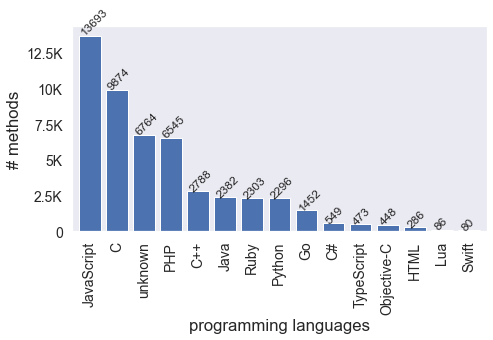

In [25]:
# at method level
pl_query = """
SELECT f.programming_language, count(DISTINCT f.file_change_id) AS file_count, count(DISTINCT m.method_change_id) AS method_count
from file_change f, method_change m
WHERE f.file_change_id=m.file_change_id
GROUP BY f.programming_language
ORDER BY method_count DESC;
"""
df_pl = pd.read_sql_query(pl_query, conn)
# dfm_pl = filterPL(dfm)  # replaced by guesslang API
fig, ax2 = plt.subplots() 
ax2 = df_pl.sort_values(by=['method_count'], ascending=False)[['programming_language','method_count']].head(15).plot.bar(
    x = 'programming_language', ax=ax2, y = 'method_count', legend=False, align='center', width=0.8, rot=90, figsize=(7,5),fontsize=14)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=45, fontsize=12)

ax2.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
ax2.set_xlabel("programming languages")
ax2.set_ylabel("# methods")
plt.tight_layout()
plt.grid()
fig.savefig(FIGURE_PATH / 'method_pl_bar.pdf')

## (At file level) Getting all the files with single (or few) lines modification for fixing the vulnerabilities.

- Option 1: adding two columns diff_added and diff_deleted from diff_parsed column

In [26]:
df_diff = df_file[df_file.programming_language=='C'].copy()
df_diff['diff_added'] = df_diff.apply(lambda row: ast.literal_eval(row.diff_parsed)['added'], axis=1)
df_diff['diff_deleted'] = df_diff.apply(lambda row: ast.literal_eval(row.diff_parsed)['deleted'], axis=1)
df_diff = df_diff.reset_index(drop=True)
df_diff.head(5)

,file_change_id,hash,filename,old_path,new_path,change_type,diff,diff_parsed,num_lines_added,num_lines_deleted,code_after,code_before,nloc,complexity,token_count,programming_language,diff_added,diff_deleted
0,98573718700688,c5be6209311d4a8f10fda37d0d3f876c1b33b77b,svr_principal.c,src/lib/kadm5/srv/svr_principal.c,src/lib/kadm5/srv/svr_principal.c,ModificationType.MODIFY,"@@ -186,7 +186,7 @@ check_1_6_dummy(kadm5_prin...","{'added': [(189, ' if (password == NULL || ...",1,1,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,1655,439,10633,C,"[(189, if (password == NULL || !(mask & KA...","[(189, if (!(mask & KADM5_ATTRIBUTES) ||)]"
1,26401283970063,cf1a0c411b2668c57c41e9c4efd15ba17b6b322c,schpw.c,src/kadmin/server/schpw.c,src/kadmin/server/schpw.c,ModificationType.MODIFY,"@@ -52,7 +52,7 @@ process_chpw_request(krb5_co...","{'added': [(55, ' goto bailout;'), (70,...",4,4,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,363,54,2230,C,"[(55, goto bailout;), (70, got...","[(55, goto chpwfail;), (70, go..."
2,75372792453382,f18ddf5d82de0ab7591a36e465bc24225776940f,spnego_mech.c,src/lib/gssapi/spnego/spnego_mech.c,src/lib/gssapi/spnego/spnego_mech.c,ModificationType.MODIFY,"@@ -818,7 +818,6 @@ init_ctx_reselect(OM_uint3...","{'added': [], 'deleted': [(821, '\tgeneric_gss...",0,1,"/*\n * Copyright (C) 2006,2008 by the Massachu...","/*\n * Copyright (C) 2006,2008 by the Massachu...",3104,512,15617,C,[],"[(821, \tgeneric_gss_release_oid(&tmpmin, &sc-..."
3,133296456517228,524688ce87a15fc75f87efc8c039ba4c7d5c197b,spnego_mech.c,src/lib/gssapi/spnego/spnego_mech.c,src/lib/gssapi/spnego/spnego_mech.c,ModificationType.MODIFY,"@@ -1468,7 +1468,7 @@ acc_ctx_cont(OM_uint32 *...","{'added': [(1471, '\tif (REMAIN == 0 || REMAIN...",1,1,"/*\n * Copyright (C) 2006,2008 by the Massachu...","/*\n * Copyright (C) 2006,2008 by the Massachu...",3104,513,15621,C,"[(1471, \tif (REMAIN == 0 || REMAIN > INT_MAX))]","[(1471, \tif (REMAIN > INT_MAX))]"
4,164723005006285,af0ed4df4dfae762ab5fb605f5a0c8f59cb4f6ca,svr_principal.c,src/lib/kadm5/srv/svr_principal.c,src/lib/kadm5/srv/svr_principal.c,ModificationType.MODIFY,"@@ -344,6 +344,20 @@ check_1_6_dummy(kadm5_pri...","{'added': [(347, '/* Return the number of keys...",18,3,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,1721,450,11053,C,"[(347, /* Return the number of keys with the n...","[(1596, int ret, l..."


-Option 2: getting the added and removed statements (an alternative method without 'diff_parsed' column).

In [27]:
import difflib

def to_diff_file(old_str, new_str):
    """
    produces a diff file comparing two files/methods.
    """
    diff = difflib.ndiff(old_str.splitlines(1), new_str.splitlines(1))
    result = '\n'.join(diff)
    return result


def separate_diff(diff):
    """
    :returns Dictionary of added and removed statements along with line number.
    """
    lines = diff.split("\n")
    added = []  # List[Tuple[int, str]]
    deleted = []  # List[Tuple[int, str]]
    count_deletions = 0
    count_additions = 0

    for line in lines:
        line = line.rstrip()
        count_deletions += 1
        count_additions += 1

        if line.startswith("-"):
            deleted.append((count_deletions, line[1:]))
            count_additions -= 1

        if line.startswith("+"):
            added.append((count_additions, line[1:]))
            count_deletions -= 1

        if line == r"\ No newline at the end of file":
            count_deletions -= 1
            count_additions -= 1

    return added, deleted

In [28]:
df_diff = df_diff[(df_diff.num_lines_added<='1') & (df_diff.num_lines_deleted<='1')].reset_index() # you can change the value 1 with the number of lines to be considered.
print('Number of files with single line modification = ' + str(len(df_diff['diff'])))

# added two columns 'vul' and 'patch' in the dataframe. 
df_diff['vul'] = None
df_diff['patch'] = None

for i in range(len(df_diff['diff'])):
    lines = df_diff['diff'][i].splitlines()
    for line in lines:
        if(line[0]=='-'):
            df_diff.loc[i, 'vul'] = line[1:].strip() # the old line refers the 'vulnerability' line.
        if(line[0]=='+'):
            df_diff.loc[i, 'patch'] = line[1:].strip() # newly added line as a patch/fix  line.
df_diff.head(5) # you will get two last columns
# 'diff_parsed' column can also be used to get this result.

Number of files with single line modification = 835


,index,file_change_id,hash,filename,old_path,new_path,change_type,diff,diff_parsed,num_lines_added,...,code_after,code_before,nloc,complexity,token_count,programming_language,diff_added,diff_deleted,vul,patch
0,0,98573718700688,c5be6209311d4a8f10fda37d0d3f876c1b33b77b,svr_principal.c,src/lib/kadm5/srv/svr_principal.c,src/lib/kadm5/srv/svr_principal.c,ModificationType.MODIFY,"@@ -186,7 +186,7 @@ check_1_6_dummy(kadm5_prin...","{'added': [(189, ' if (password == NULL || ...",1,...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,1655,439,10633,C,"[(189, if (password == NULL || !(mask & KA...","[(189, if (!(mask & KADM5_ATTRIBUTES) ||)]",if (!(mask & KADM5_ATTRIBUTES) ||,if (password == NULL || !(mask & KADM5_ATTRIBU...
1,2,75372792453382,f18ddf5d82de0ab7591a36e465bc24225776940f,spnego_mech.c,src/lib/gssapi/spnego/spnego_mech.c,src/lib/gssapi/spnego/spnego_mech.c,ModificationType.MODIFY,"@@ -818,7 +818,6 @@ init_ctx_reselect(OM_uint3...","{'added': [], 'deleted': [(821, '\tgeneric_gss...",0,...,"/*\n * Copyright (C) 2006,2008 by the Massachu...","/*\n * Copyright (C) 2006,2008 by the Massachu...",3104,512,15617,C,[],"[(821, \tgeneric_gss_release_oid(&tmpmin, &sc-...","generic_gss_release_oid(&tmpmin, &sc->internal...",None
2,3,133296456517228,524688ce87a15fc75f87efc8c039ba4c7d5c197b,spnego_mech.c,src/lib/gssapi/spnego/spnego_mech.c,src/lib/gssapi/spnego/spnego_mech.c,ModificationType.MODIFY,"@@ -1468,7 +1468,7 @@ acc_ctx_cont(OM_uint32 *...","{'added': [(1471, '\tif (REMAIN == 0 || REMAIN...",1,...,"/*\n * Copyright (C) 2006,2008 by the Massachu...","/*\n * Copyright (C) 2006,2008 by the Massachu...",3104,513,15621,C,"[(1471, \tif (REMAIN == 0 || REMAIN > INT_MAX))]","[(1471, \tif (REMAIN > INT_MAX))]",if (REMAIN > INT_MAX),if (REMAIN == 0 || REMAIN > INT_MAX)
3,7,19781207130058,82dc33da50338ac84c7b4102dc6513d897d0506a,context_time.c,src/lib/gssapi/krb5/context_time.c,src/lib/gssapi/krb5/context_time.c,ModificationType.MODIFY,"@@ -40,7 +40,7 @@ krb5_gss_context_time(minor_...","{'added': [(43, ' if (ctx->terminated || !c...",1,...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,31,5,158,C,"[(43, if (ctx->terminated || !ctx->establi...","[(43, if (! ctx->established) {)]",if (! ctx->established) {,if (ctx->terminated || !ctx->established) {
4,9,7262881820720,82dc33da50338ac84c7b4102dc6513d897d0506a,gssapiP_krb5.h,src/lib/gssapi/krb5/gssapiP_krb5.h,src/lib/gssapi/krb5/gssapiP_krb5.h,ModificationType.MODIFY,"@@ -206,6 +206,7 @@ typedef struct _krb5_gss_c...","{'added': [(209, ' unsigned int terminated ...",1,...,/* -*- mode: c; indent-tabs-mode: nil -*- */\n...,/* -*- mode: c; indent-tabs-mode: nil -*- */\n...,902,4,3335,C,"[(209, unsigned int terminated : 1;)]",[],None,unsigned int terminated : 1;


In [29]:
import pandas as pd
query = """
SELECT cv.cve_id, f.filename, f.num_lines_added, f.num_lines_deleted, f.code_before, f.code_after, cc.cwe_id
FROM file_change f, commits c, fixes fx, cve cv, cwe_classification cc
WHERE f.hash = c.hash
AND c.hash = fx.hash
AND fx.cve_id = cv.cve_id
AND cv.cve_id = cc.cve_id
AND f.num_lines_added<=1
AND f.num_lines_deleted<=1
AND f.programming_language='C';
"""
c_single_line_fixes = pd.read_sql_query(query, conn)
c_single_line_fixes.head(10)

,cve_id,filename,num_lines_added,num_lines_deleted,code_before,code_after,cwe_id
0,CVE-2012-1013,svr_principal.c,1,1,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,NVD-CWE-Other
1,CVE-2014-4343,spnego_mech.c,0,1,"/*\n * Copyright (C) 2006,2008 by the Massachu...","/*\n * Copyright (C) 2006,2008 by the Massachu...",CWE-415
2,CVE-2014-4344,spnego_mech.c,1,1,"/*\n * Copyright (C) 2006,2008 by the Massachu...","/*\n * Copyright (C) 2006,2008 by the Massachu...",CWE-476
3,CVE-2014-5352,context_time.c,1,1,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,NVD-CWE-Other
4,CVE-2014-5352,gssapiP_krb5.h,1,0,/* -*- mode: c; indent-tabs-mode: nil -*- */\n...,/* -*- mode: c; indent-tabs-mode: nil -*- */\n...,NVD-CWE-Other
5,CVE-2014-5352,gssapi_krb5.c,1,1,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,NVD-CWE-Other
6,CVE-2014-5352,inq_context.c,1,1,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,NVD-CWE-Other
7,CVE-2014-5352,k5seal.c,1,1,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,NVD-CWE-Other
8,CVE-2014-5352,k5sealiov.c,1,1,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,NVD-CWE-Other
9,CVE-2014-5352,k5unseal.c,1,1,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,/* -*- mode: c; c-basic-offset: 4; indent-tabs...,NVD-CWE-Other


## (At method level) Getting added and deleted statements from diff method for fixing the vulnerability. 

- Getting the diff file from vulnerable/old method and fix/new/modified method with the same method name of the file.
- Separating the modified statements into diff_added and diff_deleted statements.
- Making a dataset with diff_added, diff_deleted and vul_type columns.

(the generate dataset can be used for predicting patches for the vulnerabilities at method abstraction level)

In [30]:
def to_diff_file(str1, str2):
    import difflib
    diff = difflib.ndiff(str1.splitlines(1), str2.splitlines(1))
    result = ''.join(diff)
    return result

In [31]:
def to_diff_dict(str1):
    lines = str1.splitlines()
    diff_dict = {}
    added_lines = []
    deleted_lines = []
    for line in lines:
        if(line[0]=='+'):
            added_lines.append(line[1:].strip())
        if(line[0]=='-'):
            deleted_lines.append(line[1:].strip())

    diff_dict = {'added':added_lines, 'deleted':deleted_lines}
    return diff_dict

In [32]:
def separate_diff_method(diff_str):
    """returns a string of added statements and deleted statements """
    res = ast.literal_eval(diff_str)
    added_lines = []
    deleted_lines =[]
    for i in res['added']:
        added_lines.append(i.strip())

    for i in res['deleted']:
        deleted_lines.append(i.strip())

    added_str = ' '.join(added_lines) # the statements are seperated by whitespaces instead of new lines
    deleted_str = ' '.join(deleted_lines)
    return added_str, deleted_str

In [33]:
def separate_diff(diff_str):
    """returns a string of added statements and deleted statements """
    import ast
    res = ast.literal_eval(diff_str)
    added_lines = []
    deleted_lines =[]
    for i in res['added']:
        if type(i)==tuple:
            added_lines.append(i[1].strip())
        else:
            added_lines.append(i.strip())

    for i in res['deleted']:
        if type(i)==tuple:
            deleted_lines.append(i[1].strip())
        else:
            deleted_lines.append(i.strip())

    added_str = ' '.join(added_lines) # the statements are seperated by whitespaces instead of new lines
    deleted_str = ' '.join(deleted_lines)
    return added_str, deleted_str

In [34]:
# adding two columns diff_added and diff_deleted to the dataframe

diff_query ="""
SELECT f.programming_language, f.file_change_id, m.name, m.code, m.before_change
from file_change f, method_change m
WHERE m.file_change_id=f.file_change_id
AND f.programming_language='C'
"""
diff_method = pd.read_sql_query(diff_query, conn)
#diff_method = diff_method[diff_method.programming_language=='C'].reset_index(drop=True)
diff_result = pd.DataFrame(columns=['diff_added', 'diff_deleted'])

for i in range(0, len(diff_method)-1, 2):
    if str(diff_method['file_change_id'].iloc[i]) == str(diff_method['file_change_id'].iloc[i+1]) \
    and str(diff_method['name'].iloc[i]) == str(diff_method['name'].iloc[i+1]):   
        diff_file = to_diff_file(diff_method.code[i], diff_method.code[i+1])
        diff_dict = to_diff_dict(diff_file)
        added, deleted = separate_diff(str(diff_dict))
        diff_result = diff_result.append({'diff_added': added, 
                                          'diff_deleted': deleted}, ignore_index=True)
diff_result.head(5)

,diff_added,diff_deleted
0,if (password == NULL || !(mask & KADM5_ATTRIBU...,if (!(mask & KADM5_ATTRIBUTES) ||
1,goto chpwfail; goto chpwfail; goto chpwfail; g...,goto bailout; goto bailout; goto bailout; goto...
2,"int ret, last_pwd; ret...","int ret, last_pwd, n_n..."
3,if (ent == NULL) { st = KRB5_KDB_NOENTRY; goto...,if (ent != NULL) { if ((st = populate_policy(c...
4,krb5_key_data *key_data; if (n_key_data <= 0) ...,krb5_key_data *key_data = NULL; if (n_key_data...
